# Opportunity Gap Analysis in Melbourne
Analysis using data collected on DoorDash using scrpaing technique.

In [17]:
import glob
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import re
import json
from geopandas import GeoDataFrame
from shapely.geometry import Point
from collections import Counter

## Data

In [18]:
DATA_PATH = "/Users/leo/Development/food/data"

WEST_LIMIT = 144.58636245678318
EAST_LIMIT = 145.52543159101887
NORT_LIMIT = -37.50749853264523
SOUTH_LIMIT = -38.453343876113394

In [19]:
all_files = glob.glob(os.path.join(DATA_PATH , "MEL/listing/*/*.csv"), recursive=False)
df_stores = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_stores = df_stores.drop_duplicates("store_id")

# eliminate stores outside of melbourne
mask = (SOUTH_LIMIT < df_stores.lat) & (df_stores.lat < NORT_LIMIT) & (WEST_LIMIT < df_stores.lng) & (df_stores.lng < EAST_LIMIT)
df_stores = df_stores[mask]

In [24]:
df_stores["price_category"] = df_stores.categories.apply(lambda s: s.count("$"))
df_stores["tags"] = df_stores.categories.apply(lambda s: re.split("\s*,\s*", s.replace("$", "").replace(" • ", "")))

# remove concenience stores
mask = df_stores.tags.apply(lambda l: "Grocery" not in l) & df_stores.tags.apply(lambda l: "Convenience" not in l)
df_stores = df_stores[mask].copy()

In [48]:
# demand index
average_demand = (df_stores.n_reviews.sum() / df_stores.shape[0])

df_stores["demand_index"] = df_stores.n_reviews / average_demand

In [25]:
df_stores.shape

(5301, 29)

In [21]:
# load suburbs in victoria
victoria = geopandas.read_file("/Users/leo/Development/food/geo/victoria_suburbs.geojson.json")
victoria = victoria[["loc_pid", "vic_loca_2", "geometry"]]
victoria = victoria.rename(columns={"vic_loca_2": "suburb", "loc_pid": "suburb_id"})
# normalize suburb names
victoria["suburb"] = victoria.suburb.str.title()


# add subburb to store dataset
geometry = [Point(xy) for xy in zip(df_stores.lng, df_stores.lat)]
gdf = GeoDataFrame(df_stores, crs="EPSG:4283", geometry=geometry)
gdf = gdf.sjoin(victoria, how="inner", predicate='intersects')
df_stores = pd.DataFrame(gdf.drop(columns='geometry'))
del geometry

In [22]:
# select suburb with at least 10 stores
store_suburbs = (gdf
 .groupby("suburb_id")
 .agg({"suburb": "first", "store_id": "count"})
 .query("store_id >= 10")
).index.values
del gdf
victoria = victoria[victoria.suburb_id.isin(store_suburbs)]

## Summary

In [44]:
print("There are %s stores on Doordash in Melbourne" % df_stores.shape[0])

There are 5301 stores on Doordash in Melbourne


## Market Share

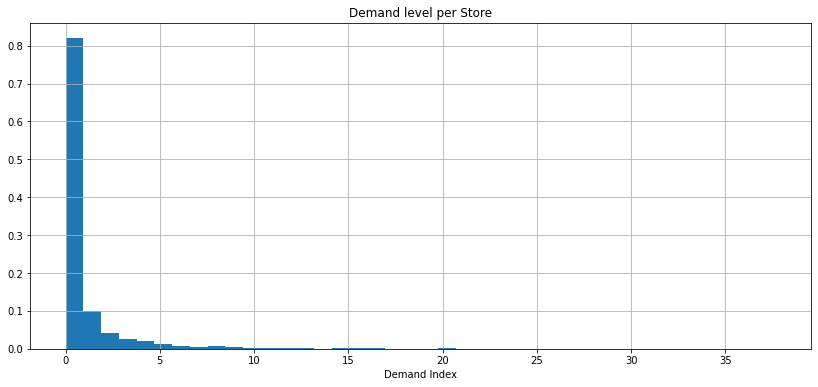

In [66]:
fig, ax = plt.subplots(figsize=(14, 6))
df_stores.demand_index.hist(bins=40,density=True);
plt.xlabel('Demand Index');
plt.title('Demand level per Store');

In [68]:
df_business = (df_stores
 .groupby("business_id", as_index=False)
 .agg({"name": "first",
       "store_id": "count",
       "n_reviews": "sum",
       "rating": "mean",
       "tags": "first",
       "price_category": "mean"
      })
 .sort_values("n_reviews", ascending=False)
)

df_business = df_business.rename(columns={"store_id": "n_stores"})
df_business["business_id"] = df_business.business_id.astype(int)
df_business["price_category"] = df_business.price_category.round().astype(int)

df_business["stores_demand_index"] = (df_business.n_reviews / df_business.n_stores) / average_demand

df_business["market_share_index"] = 100 * (df_business.n_reviews / df_business.n_reviews.sum())
df_business["market_share_cumsum"] = df_business.market_share_index.cumsum()

In [72]:
print("%s restaurant brands - %s brands represent 70%% of market share" %\
      (df_business.shape[0], (df_business.market_share_cumsum < 70.5).sum()))

4278 restaurant brands - 330 brands represent 70% of market share


In [73]:
df_business.head(10)

,business_id,name,n_stores,n_reviews,rating,tags,price_category,stores_demand_index,market_share_index,market_share_cumsum
751,393499,McDonald's,32,73019.0,4.071368,"[American, Burgers]",2,12.850684,7.757440,7.757440
599,341404,Grill'd,19,22487.0,4.514072,"[Burgers, Sandwiches]",2,6.665278,2.388989,10.146429
762,403575,Guzman y Gomez,12,18881.0,4.357888,"[Mexican, Burritos]",2,8.861028,2.005892,12.152321
826,415267,KFC,25,16256.0,4.195673,"[Chicken, Fried Chicken]",2,3.661964,1.727016,13.879336
454,321896,Nando's,16,13842.0,4.412527,"[Chicken, Salads]",2,4.872134,1.470555,15.349892
2110,860686,Hungry Jacks,15,12598.0,4.093021,"[Burgers, American]",2,4.729886,1.338395,16.688286
448,321645,Schnitz,14,9039.0,4.443817,"[Australian, Schnitzel]",1,3.636074,0.960291,17.648577
172,295155,Hecho en Mexico,6,7773.0,4.471820,"[Mexican, Burritos]",2,7.295882,0.825793,18.474370
1105,464981,Taco Bell,3,7646.0,4.228326,"[Mexican, Tacos]",2,14.353354,0.812301,19.286671
480,327788,Subway,35,7569.0,4.351508,"[Burgers, Healthy]",2,1.217898,0.804120,20.090792


## Suburbs

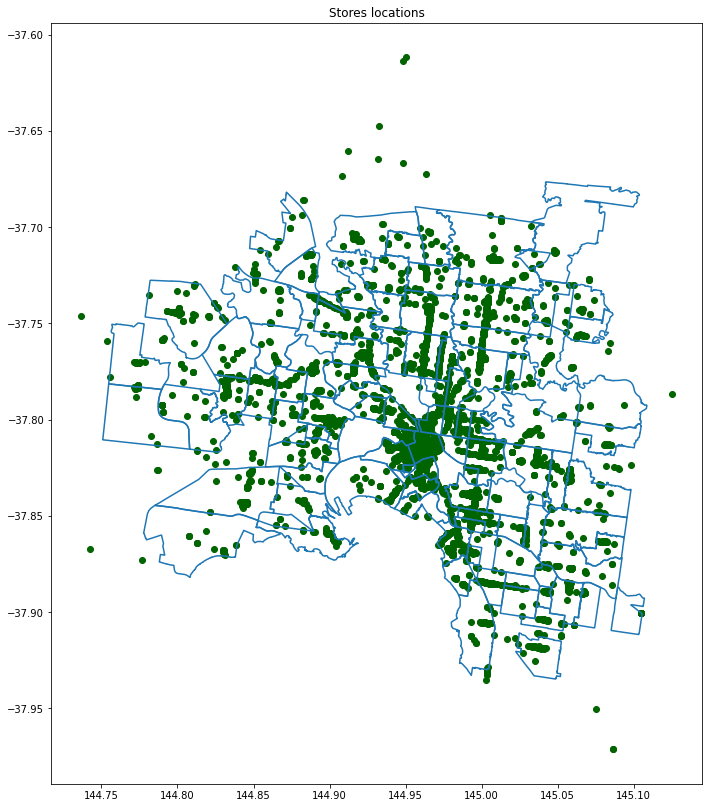

In [74]:
fig, ax = plt.subplots(figsize=(14, 14))

victoria.boundary.plot(ax=ax);
ax.scatter(x=df_stores.lng.values, y=df_stores.lat.values, color="darkgreen");
plt.title("Stores locations");

In [84]:
df_suburb_counter = df_stores.groupby("suburb").agg({"store_id": "count", "n_reviews": "sum"})
df_suburb_counter = df_suburb_counter.rename(columns={"store_id": "n_stores"})
df_suburb_counter["perc_stores"] = (df_suburb_counter.n_stores / df_stores.shape[0] * 100).round(1)
df_suburb_counter["perc_reviews"] = (df_suburb_counter.n_reviews / df_stores.n_reviews.sum() * 100).round(1)
df_suburb_counter["store_demand"] = df_suburb_counter.n_reviews / df_suburb_counter.n_stores
df_suburb_counter["stores_demand_index"] = df_suburb_counter.store_demand / average_demand
df_suburb_counter["stores_demand_perc_lift"] = ((df_suburb_counter.stores_demand_index  - 1) * 100).round(0)

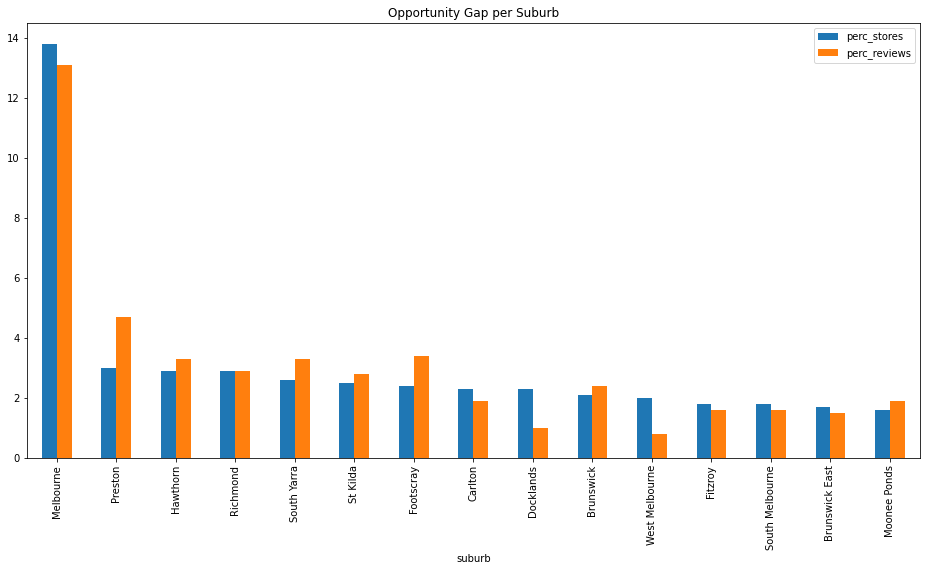

In [87]:
(df_suburb_counter
 .query("n_stores >= 10")
 .sort_values("perc_stores", ascending=False)
 .head(15)
 [['perc_stores', 'perc_reviews']]
).plot.bar(figsize=(16,8));

plt.title("Opportunity Gap per Suburb");

In [90]:
# Suburbs with highest store performance
(df_suburb_counter
 .query("n_stores >= 10")
 .sort_values("stores_demand_index", ascending=False)
 .round(1)
 .head(10)
 [['n_stores', 'perc_stores', 'perc_reviews', 'stores_demand_index']]
)

,n_stores,perc_stores,perc_reviews,stores_demand_index
suburb,,,,
Flemington,38,0.7,2.1,3.0
East Melbourne,11,0.2,0.5,2.6
Essendon North,11,0.2,0.5,2.6
Deer Park,19,0.4,0.9,2.6
Maribyrnong,69,1.3,3.3,2.5
Yarraville,49,0.9,2.1,2.2
St Albans,43,0.8,1.6,2.0
Sunshine,69,1.3,2.6,2.0
West Footscray,26,0.5,1.0,1.9


## Tags

In [91]:
t_counter = Counter()
for t in df_stores.tags.values:
    t_counter.update(t)

df_tag_counter = pd.DataFrame(t_counter.most_common(), columns=["tag", "n_stores"])


t_rev_counter = Counter()
for _, row in df_stores.iterrows():
    t_rev_counter.update(row.tags * int(row.n_reviews))

df_tag_counter = df_tag_counter.merge(pd.DataFrame(t_rev_counter.most_common(), columns=["tag", "n_reviews"]),
                how='outer', on="tag")

df_tag_counter["perc_stores"] = df_tag_counter.n_stores / df_stores.shape[0] * 100
df_tag_counter["perc_reviews"] = df_tag_counter.n_reviews / df_stores.n_reviews.sum() * 100

df_tag_counter["store_demand"] = df_tag_counter.n_reviews / df_tag_counter.n_stores


average_demand = (df_stores.n_reviews.sum() / df_stores.shape[0])

df_tag_counter["store_demand_index"] = (df_tag_counter.store_demand / average_demand)
df_tag_counter.

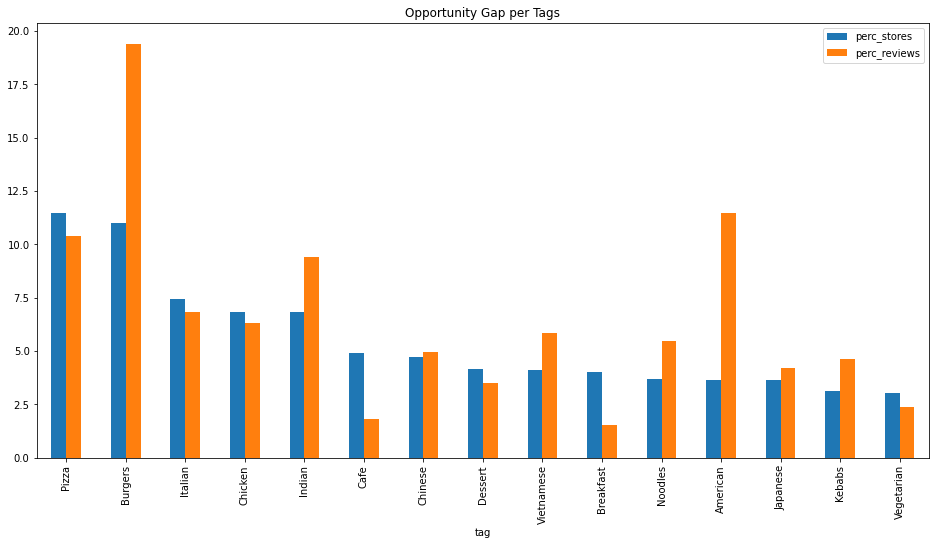

In [94]:
(df_tag_counter
 .set_index("tag")
 .query("n_stores >= 10")
 .sort_values("perc_stores", ascending=False)
 .head(15)
 [['perc_stores', 'perc_reviews']]
).plot.bar(figsize=(16,8));

plt.title("Opportunity Gap per Tags");

In [99]:
(df_tag_counter.query("n_stores > 5")
 .sort_values("store_demand_index", ascending=False)
 .head(20)
 .
)

,tag,n_stores,n_reviews,perc_stores,perc_reviews,store_demand,store_demand_index
135,Korean Fried Chicken,9,6372.0,0.169779,0.676953,708.000000,3.987251
43,Burritos,57,38784.0,1.075269,4.120360,680.421053,3.831935
128,Roast Chicken,11,6790.0,0.207508,0.721360,617.272727,3.476302
11,American,194,107933.0,3.659687,11.466656,556.355670,3.133234
49,Malaysian,52,24663.0,0.980947,2.620164,474.288462,2.671056
119,Poke,12,5472.0,0.226372,0.581338,456.000000,2.568060
27,Mexican,113,49635.0,2.131673,5.273156,439.247788,2.473717
143,Frozen Yogurt,8,3322.0,0.150915,0.352925,415.250000,2.338568
74,Rice Bowl,30,11644.0,0.565931,1.237043,388.133333,2.185855
113,Rolls,13,4969.0,0.245237,0.527900,382.230769,2.152613


In [103]:
df_stores.to_csv("/Users/leo/Development/food/data/analysis/MEL_stores.csv", index=False)


In [107]:
(victoria
 .merge(df_suburb_counter.reset_index().round(2), on="suburb")
 .to_file('/Users/leo/Development/food/data/analysis/MEL_suburbs_analysis.geojson', driver='GeoJSON')
)